# Offline learning with a loan pricing example

In [ ]:
    _coef_1 = [1, 0.15] #true_coefs[ind]
    _cost_of_risk_1 = 0.3 #cost_of_risk[ind]
    _conv_effect_of_interest_rate_1 = -0.5   #about 10% effect


    _coef_2 = [1, 0.2] #true_coefs[ind]
    _cost_of_risk_2 = 0.5 #cost_of_risk[ind]
    _conv_effect_of_interest_rate_2 = 0   #0 effect

In [121]:
import numpy as np
from numpy.typing import NDArray
from scipy.special import expit


class LoanOracle:
    def __init__(self):
        self.context = None
        self.rewards = [] 
        self.optimal_rewards = [] 
        self.expected_rewards = []  # p of the article chosen for the given context

        self.true_coefs = np.array(
            [
                [1, 0.2],
                [1, 0.15]
            ]
        )
        self.cost_of_risk = np.array([0.5, 0.3])
        
        # Action 1 (interest rate 10%) doesn't have any effect on conversion rate
        # Action 2 (interest rate 15%) reduces conversion rate by 0.5
        self.conv_effect_of_interest_rate = np.array([0, -0.5])

    def set_context(self, context: NDArray[np.float64]):

        self.context = context

    def generate_reward(self, _coef: NDArray[np.float64], _cost_of_risk: float,
            _conv_effect_of_interest_rate: float) -> int:
        assert self.context is not None

        #Probability of conversion
        p_conversion = expit(np.dot(self.context, _coef) + _conv_effect_of_interest_rate)
        conversion = np.random.binomial(1, p_conversion)

        reward = conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        expected_reward = p_conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        self.rewards.append(reward)
        self.expected_rewards.append(expected_reward)
        return reward

    def best_expected_reward(self):
        assert self.context is not None

        p_conversions = expit(np.dot(self.context, self.true_coefs.T) + self.conv_effect_of_interest_rate)
        expected_rewards = p_conversions * (np.dot(self.context, self.true_coefs.T) - self.cost_of_risk)
        self.optimal_rewards.append(
            np.max(expected_rewards)
        )

    def interest_rate_10(self):
        """
        10% interest rate
        Works well for contexts where x < 2
        """
        return self.generate_reward(self.true_coefs[0], self.cost_of_risk[0], self.conv_effect_of_interest_rate[0])

    def interest_rate_15(self):
        """
        15% interest rate
        Works well for contexts where x > 2
        """
        return self.generate_reward(self.true_coefs[1], self.cost_of_risk[1], self.conv_effect_of_interest_rate[1])





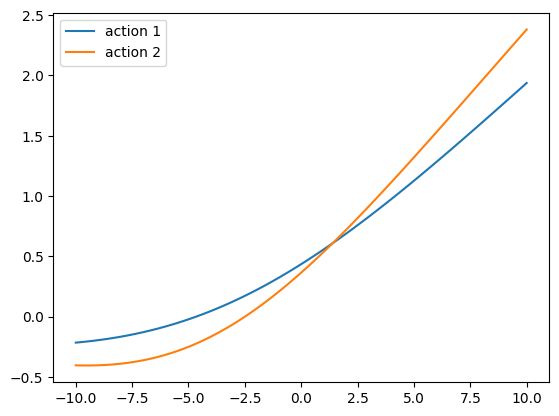

In [84]:
import matplotlib.pyplot as plt
#Expit takes values between -10 and 10
expected_rewards_for_action_1 = []
expected_rewards_for_action_2 = []
xs = np.linspace(-10, 10, 100)

for x in xs:

    context = np.array([1.0, x])

    _coef_1 = [1, 0.15] #true_coefs[ind]
    _cost_of_risk_1 = 0.3 #cost_of_risk[ind]
    _conv_effect_of_interest_rate_1 = -0.5   #about 10% effect

    p_conversion_1 = expit(np.dot(context, _coef_1) + _conv_effect_of_interest_rate_1)
    conversion_1 = np.random.binomial(1, p_conversion_1)

    expected_reward_1 = p_conversion_1 * (np.dot(context, _coef_1) - _cost_of_risk_1)
    expected_rewards_for_action_1.append(expected_reward_1)


    _coef_2 = [1, 0.2] #true_coefs[ind]
    _cost_of_risk_2 = 0.5 #cost_of_risk[ind]
    _conv_effect_of_interest_rate_2 = 0   #0 effect

    p_conversion_2 = expit(np.dot(context, _coef_2) + _conv_effect_of_interest_rate_2)
    conversion_2 = np.random.binomial(1, p_conversion_2)

    expected_reward_2 = p_conversion_2 * (np.dot(context, _coef_2) - _cost_of_risk_2)
    expected_rewards_for_action_2.append(expected_reward_2)

plt.plot(xs, expected_rewards_for_action_1, label="action 1")
plt.plot(xs, expected_rewards_for_action_2, label="action 2")
plt.legend()



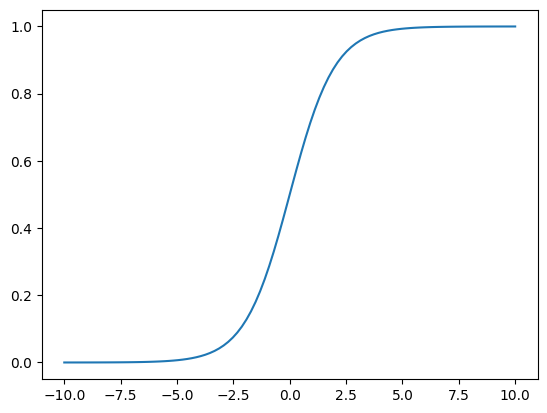

In [67]:
#plot expit function
import matplotlib.pyplot as plt
plt.plot(np.linspace(-10, 10, 100), expit(np.linspace(-10, 10, 100)))
plt.show()


In [122]:
from enum import Enum

class InterestRate(Enum):
    interest_rate_10 = 1
    interest_rate_15 = 2

    def take_action(self, oracle: LoanOracle):
        if self == InterestRate.interest_rate_10:
            return oracle.interest_rate_10()
        elif self == InterestRate.interest_rate_15:
            return oracle.interest_rate_15()
        else:
            raise ValueError("invalid param")


In [123]:
from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    ContextualAgent,
    UpperConfidenceBound
)

arms = [
    Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
    Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
]


agent = ContextualAgent(
    arms=arms,
    policy=UpperConfidenceBound(0.68),
)

oracle = LoanOracle()
    

In [124]:
np.random.seed(111)

for _ in range(5000):

    #user_gender = np.random.binomial(1, 0.5) # 0 corresponds to female
    user_age = np.random.randint(-5, 5) 

    context = np.array([1.0, user_age])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    agent.update(context, oracle.rewards[-1]) #Do I need to normalize this?


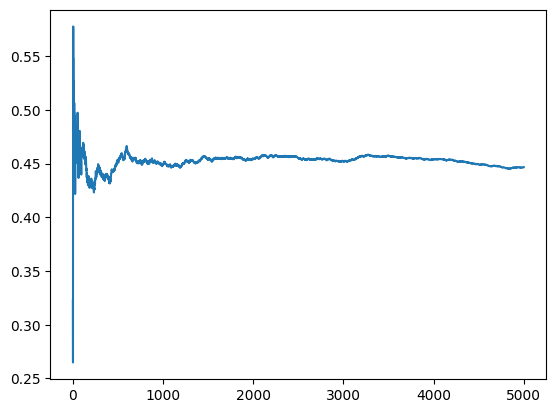

In [125]:
# Rolling average of the expected rewards
rolling_avg_expected_rewards = np.cumsum(oracle.expected_rewards) / np.arange(1, len(oracle.expected_rewards) + 1)
plt.plot(rolling_avg_expected_rewards, label="Rolling average expected rewards")


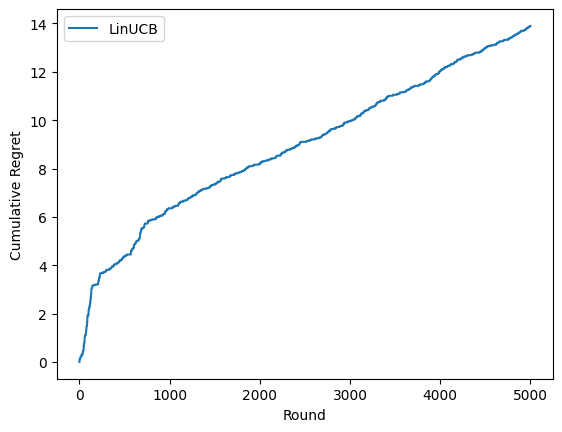

In [126]:
import matplotlib.pyplot as plt

linucb_regret = np.cumsum(
    np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
)

plt.plot(linucb_regret, label="LinUCB")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()

In [129]:
from bayesianbandits import ThompsonSampling

thompson_oracle = LoanOracle()

thompson_agent = ContextualAgent(
    arms = [
    Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
    Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
    ],
    policy=ThompsonSampling(),
)

np.random.seed(111)

for _ in range(5000):

    user_age = np.random.randint(-5, 5) 
    context = np.array([1.0, user_age])

    thompson_oracle.set_context(context)
    thompson_oracle.best_expected_reward()

    action, = thompson_agent.pull(context)
    action.take_action(thompson_oracle)
    thompson_agent.update(context, thompson_oracle.rewards[-1] - 0.5)


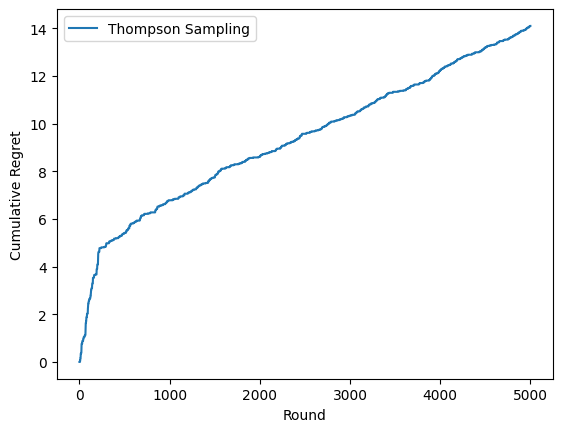

In [130]:
thompson_regret = np.cumsum(
    np.array(thompson_oracle.optimal_rewards) - np.array(thompson_oracle.expected_rewards)
)

plt.plot(thompson_regret, label="Thompson Sampling")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()

In [ ]:
#action: interest rate

# reward = p(c) * v
# reward = 